In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from itertools import product

sns.set_style('darkgrid')

In [2]:
data = pd.read_csv('../data/processed_files/processed_data.csv')
data['date'] = pd.to_datetime(data['date'])

## Adding some helpful columns to the data

In [3]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

data['year'] = data['date'].dt.year
data['month'] = pd.Categorical(data['date'].dt.month_name(), categories=months_order)
data['day'] = data['date'].dt.day
data['week_day'] = pd.Categorical(data['date'].dt.day_name(), categories=day_order)
data['revenue'] = data['item_cnt_day'] * data['item_price']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2895398 entries, 0 to 2895397
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        int64         
 6   item_name           object        
 7   item_category_id    int64         
 8   shop_name           object        
 9   item_category_name  object        
 10  year                int32         
 11  month               category      
 12  day                 int32         
 13  week_day            category      
 14  revenue             float64       
dtypes: category(2), datetime64[ns](1), float64(2), int32(2), int64(5), object(3)
memory usage: 270.6+ MB


## look at the relations between target and other columns


#### numerical data

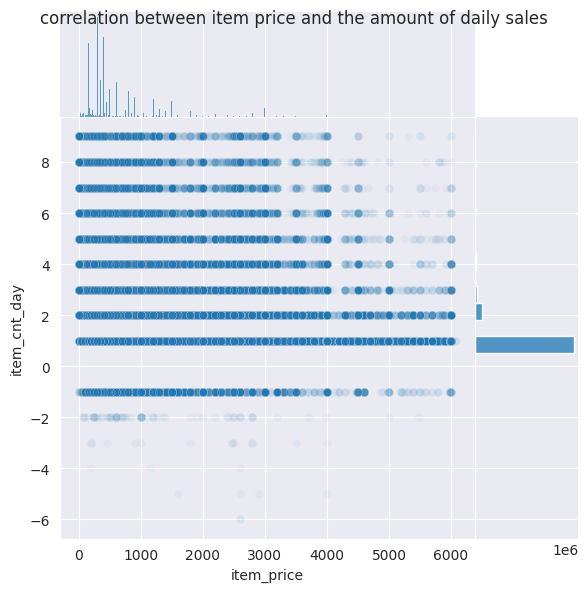

In [5]:
grid = sns.jointplot(data=data[['item_cnt_day', 'item_price']], x='item_price', y='item_cnt_day', space=0, ratio=4, joint_kws={'alpha':0.05})
grid.figure.suptitle('correlation between item price and the amount of daily sales')
plt.show()

# the graph is really bad, but I couldn't find a better way to visualise this

From what we see on the figure, we can colclude that cheaper items are sold (and returned) more often overall, and items are mostly sold once or twice a day

#### categorial data

here I'm trying to see a distibution of the amount of items sold daily with respect to different values of categorial columns

In [18]:
def barplots(df: pd.DataFrame, columns: list[str], target = 'item_cnt_day', aggregation : str = 'sum', title: str = None, show_line = False):
    plt.figure(figsize=(20, 5*len(columns)))
    if title:
        plt.suptitle(title, fontsize=16)

    for idx, col in enumerate(columns):
        data_to_plot = None
        if aggregation == 'sum':
            data_to_plot = data[[target, col]].groupby(col).sum()
        if aggregation == 'mean':
            data_to_plot = data[[target, col]].groupby(col).mean()
        if aggregation == 'max':
            data_to_plot = data[[target, col]].groupby(col).max()
        plt.subplot(len(columns), 1, idx+1)
        sns.barplot(data_to_plot, x=col, y=target, hue=col, palette=sns.color_palette('Set2'), legend=False)
        if show_line:
            sns.lineplot(data=data_to_plot, x=col, y=target,
                        palette=sns.color_palette('Set2'))
    plt.subplots_adjust(bottom=0.1,
                        top=0.9,
                        hspace=0.2)
    plt.show()

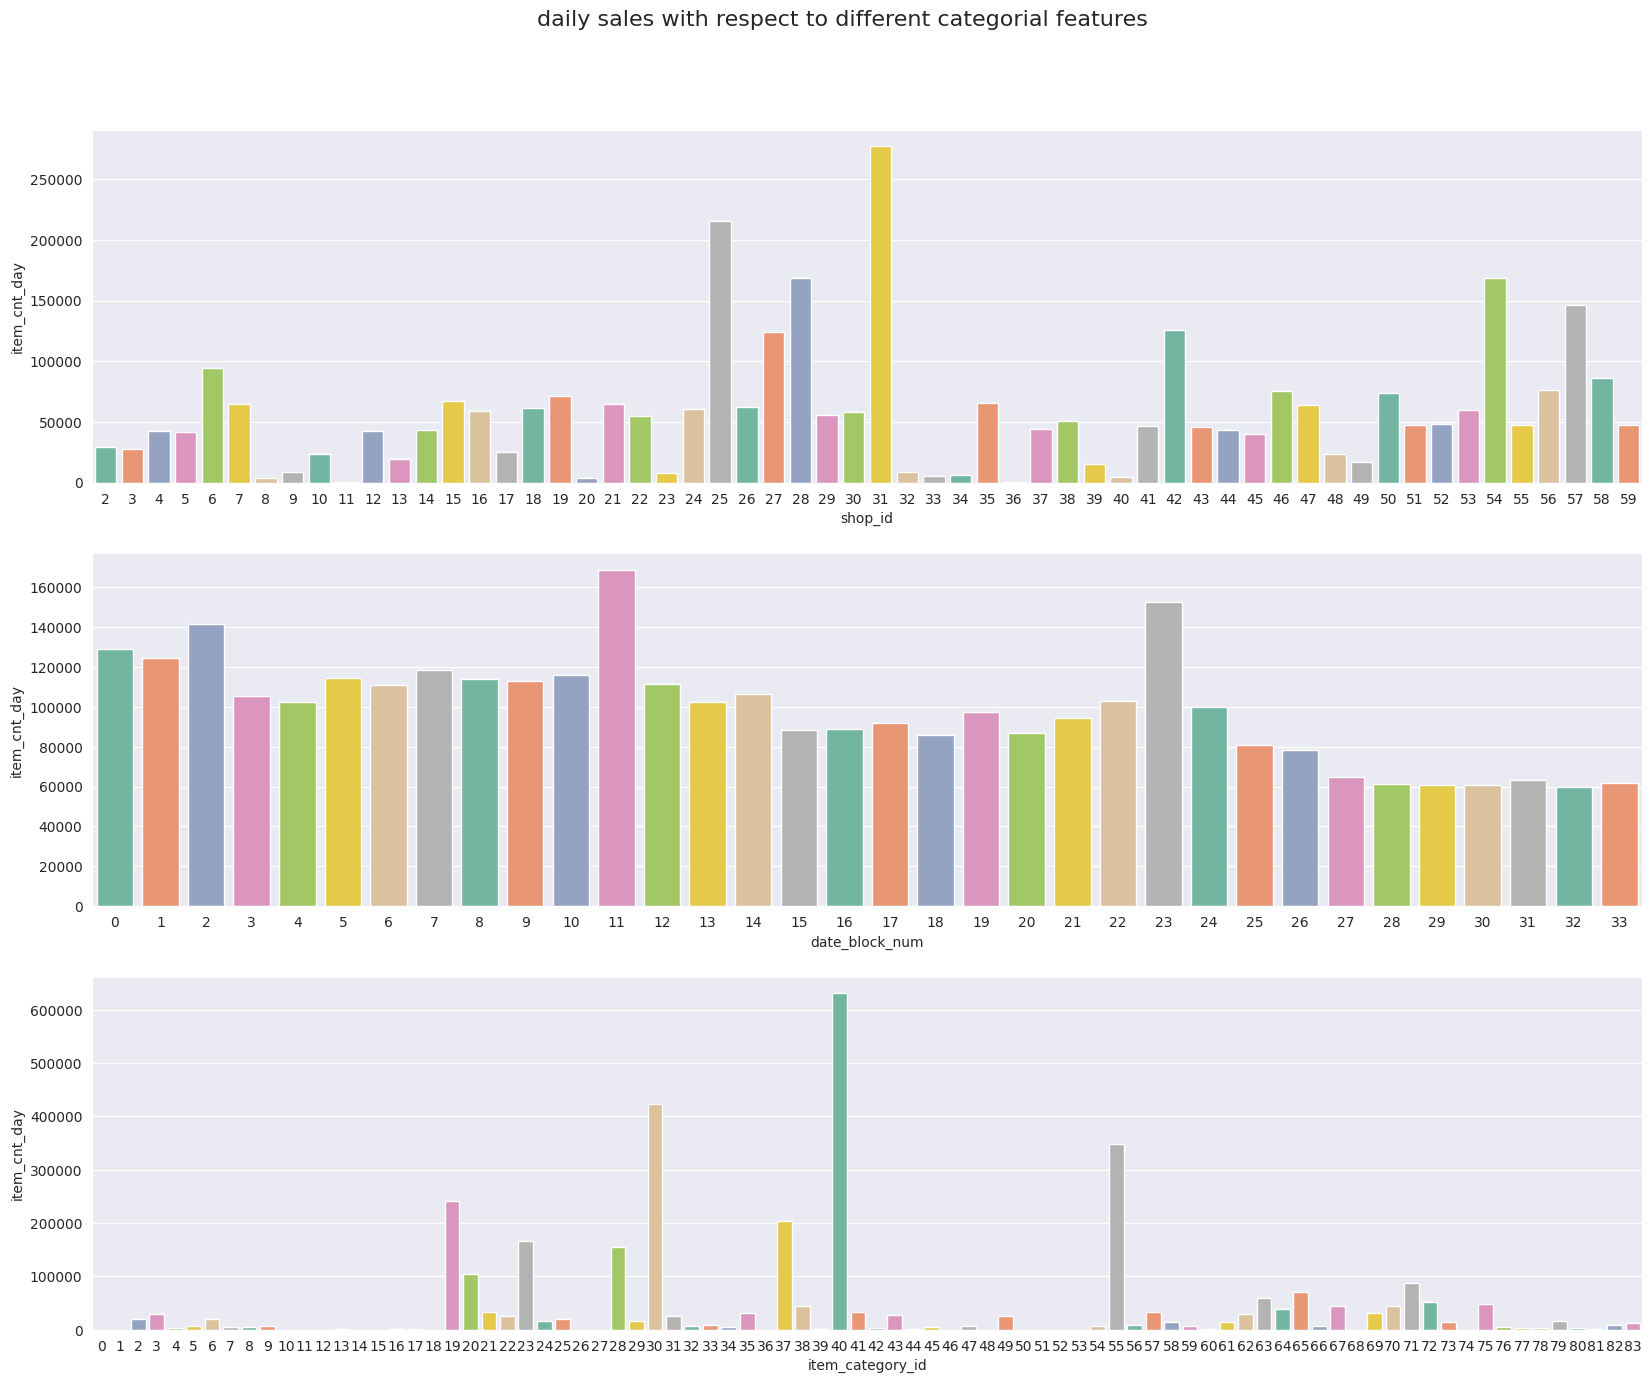

In [16]:
cols = ['shop_id', 'date_block_num', 'item_category_id']

barplots(data, cols, title='daily sales with respect to different categorial features', aggregation='sum')

the amount of items sold has a sigificant drop around the 24th month mark, so let's see it as a line as well

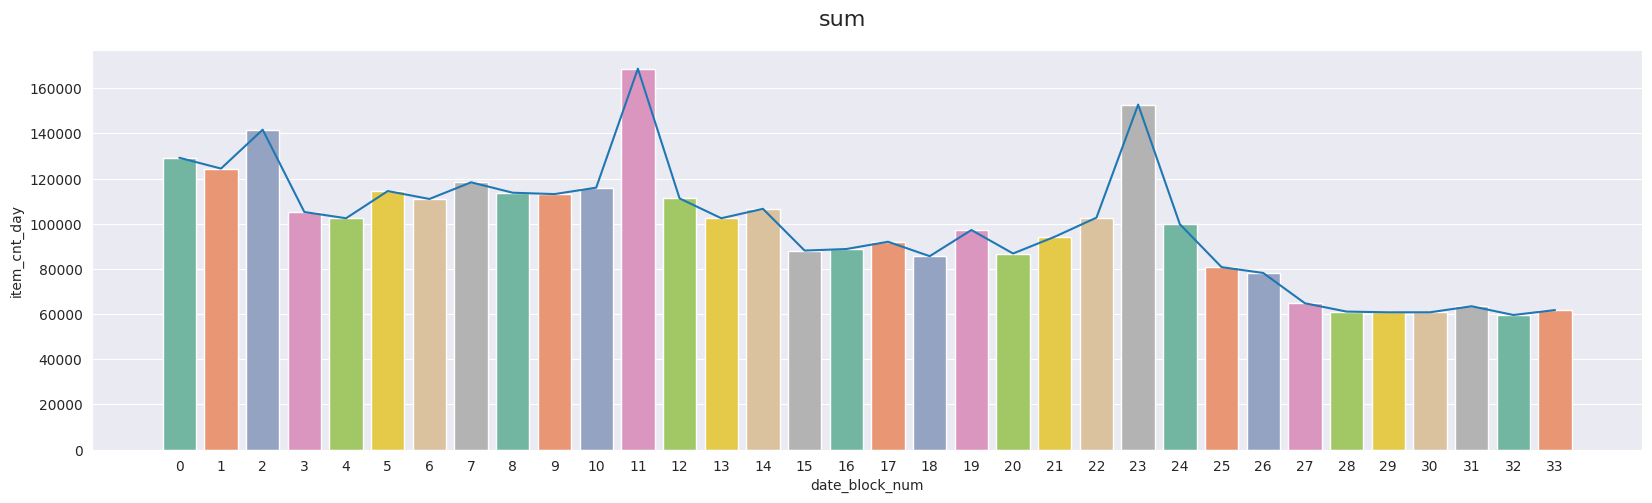

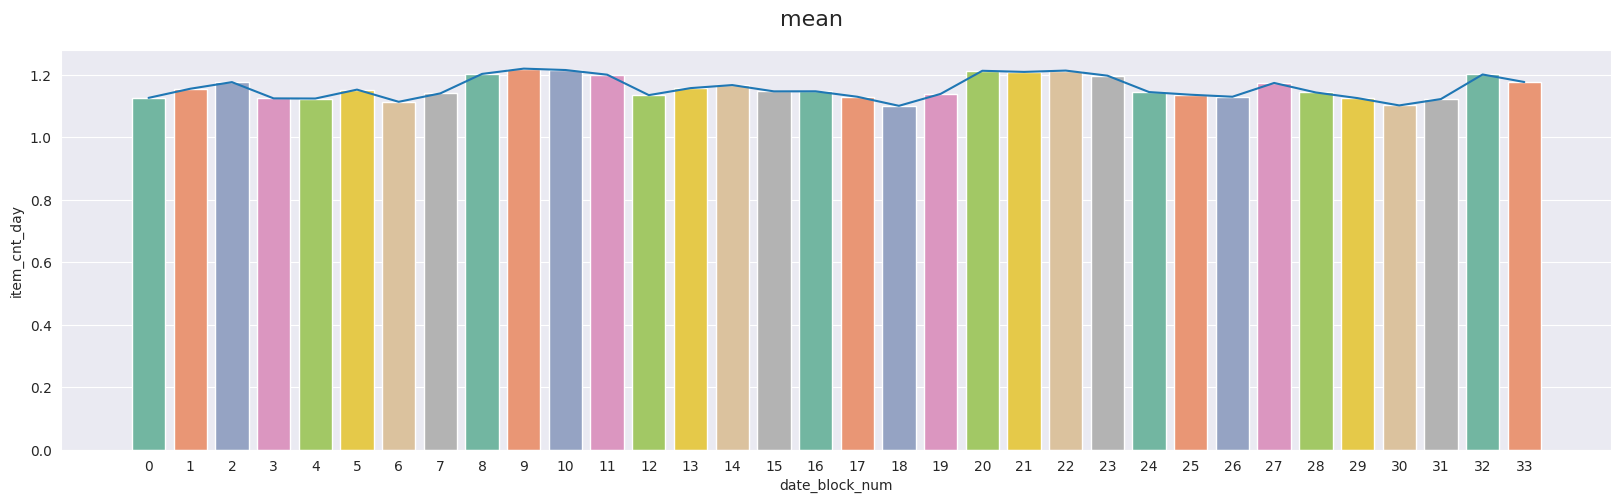

In [23]:
barplots(data, ['date_block_num'], aggregation='sum', show_line=True, title='sum')
barplots(data, ['date_block_num'], aggregation='mean', show_line=True, title='mean')

we can see that the amount of items sold increases every 12 months (which we already saa during DQC) and remains approx. the same during the whole period (though, the overall sales do decrease a little by the end of the period)

at the same time, we can see that the amount of items sold has quite a high variance depending on the category and the shop, so that gives us a hint that those two columns will be an important factor while predicting the future sales.

also, we can see that the overall revenue during the last few months decreased a lot, while mean spiked to its all-time highest value. this probably means that by the end of the period pople started buying more expensive items, and less cheap ones

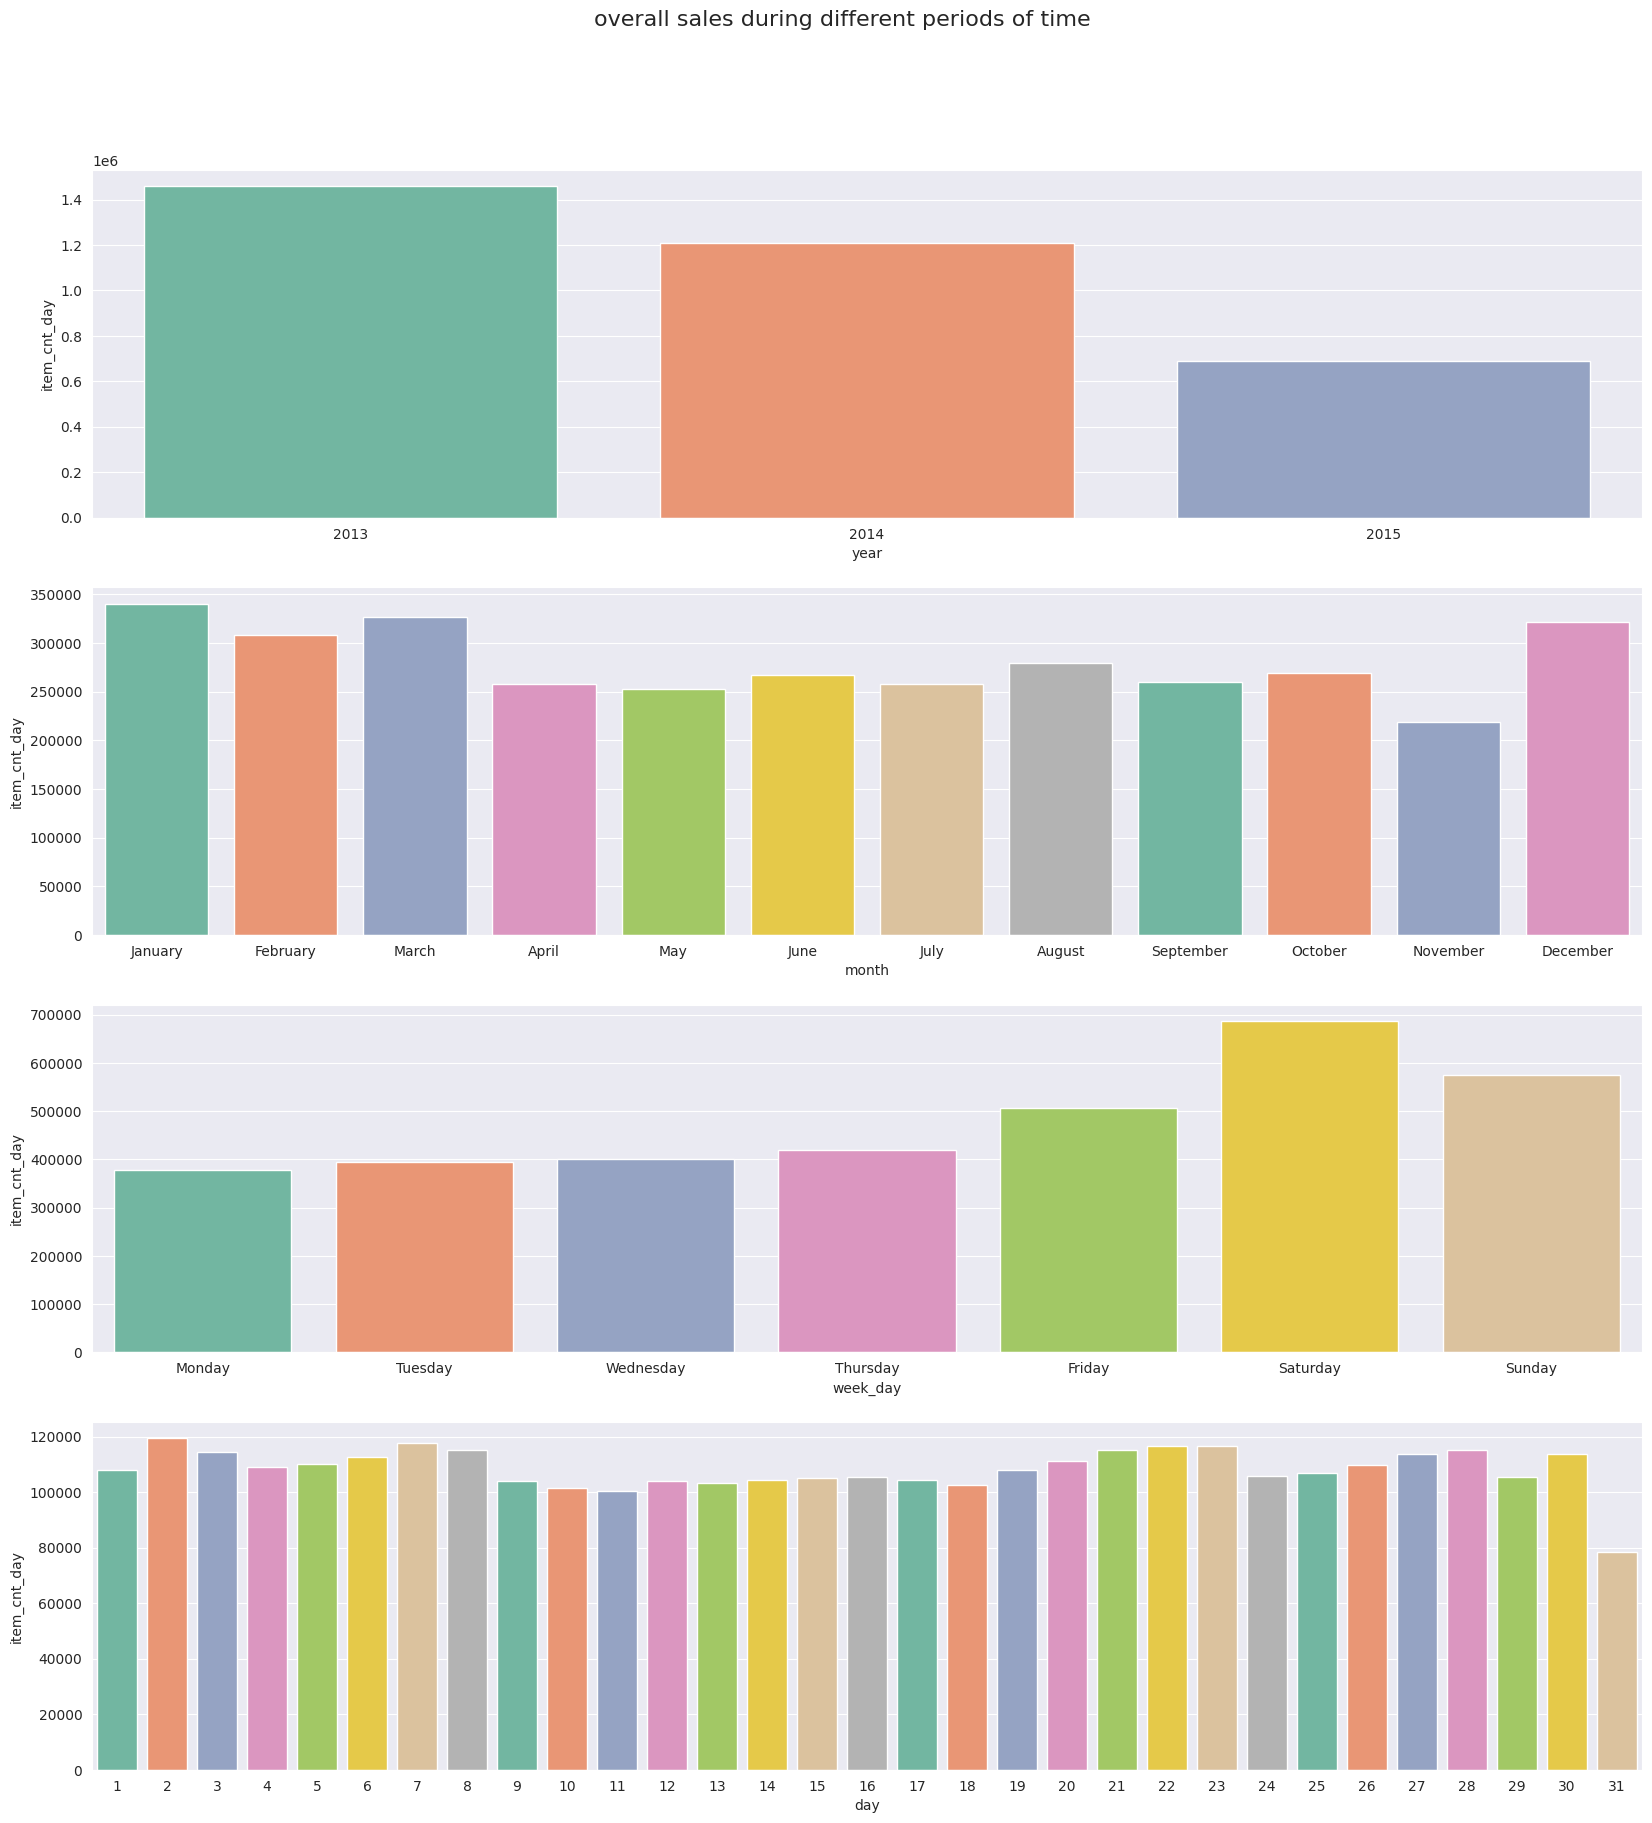

In [24]:
cols = ['year', 'month', 'week_day', 'day']

barplots(data, cols, title='overall sales during different periods of time')

these three plots show us the following information:
- as expected, the sales drop over time, we can see the amount of items sold decrease each year. the sales over the last year are approx. twice as low as during the first year
- there's no strong trend of the amount of items sold over the course of one year. however, the sales rise around the new year (and, apparently, in march)
- sales remain approx. the same over the working days, but rise drastically from friday to sunday (esp. on saturday)
- overall sales do not depend on the day of the month (we can see a drop at 31, but that's probably due to the fact that some months have only 30 days)

since this data seems quite significant, it may be a good thing to include those values as input for the future model

#### observing mean vs sum

up until now I've been looking only at the sum of values grouped by a certain criteria. that was done, because there's a lot of 1's and 0's in our data, so if we used mean as a metric, the higher (but way less frequent) values would just fade away

now, I wanna compare the same stats using thir sum and mean to see if there's maybe some unusual correlation (like, for example, tendency for people to buy a lower amount of higher-priced items in the middle of the month)

## correlations between other values

#### categorial features

first of all we can build contingency tables for different catrgorial features to se how they relate to each other.

In [12]:
def cont_tables(df: pd.DataFrame, columns: list[str]):
    template = "correlation between {:17} and {:17}\tchi-value: {:12.3f}, p-value: {:3.2f}"
    for col_1, col_2 in product(columns, repeat=2):
        if col_1==col_2: continue
        cont_table = pd.crosstab(df[col_1], df[col_2])
        chi, pvalue, dof, expectations = chi2_contingency(cont_table)
        print(template.format(col_1, col_2, chi, pvalue))

In [13]:
cont_tables(data, ['date_block_num', 'item_category_id', 'shop_id']) #looks pretty weird to me :D

correlation between date_block_num    and item_category_id 	chi-value:   532772.557, p-value: 0.00
correlation between date_block_num    and shop_id          	chi-value:   447599.914, p-value: 0.00
correlation between item_category_id  and date_block_num   	chi-value:   532772.557, p-value: 0.00
correlation between item_category_id  and shop_id          	chi-value:  3863364.430, p-value: 0.00
correlation between shop_id           and date_block_num   	chi-value:   447599.914, p-value: 0.00
correlation between shop_id           and item_category_id 	chi-value:  3863364.430, p-value: 0.00


each pair of those has a p-value of 0, so that's weird, need to address this later